# **Project Big Data with fastai**



In [4]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 12.8 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 189 kB 45.0 MB/s 
     |████████████████████████████████| 1.2 MB 49.2 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 314 kB/s 
Mounted at /content/gdrive


In [5]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!unzip data.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: data/federal/federal321.png  
  inflating: data/federal/federal322.png  
  inflating: data/federal/federal323.png  
  inflating: data/federal/federal324.png  
  inflating: data/federal/federal325.png  
  inflating: data/federal/federal326.png  
  inflating: data/federal/federal327.png  
  inflating: data/federal/federal328.png  
  inflating: data/federal/federal329.png  
  inflating: data/federal/federal33.png  
  inflating: data/federal/federal330.png  
  inflating: data/federal/federal331.png  
  inflating: data/federal/federal332.png  
  inflating: data/federal/federal333.png  
  inflating: data/federal/federal334.png  
  inflating: data/federal/federal335.png  
  inflating: data/federal/federal336.png  
  inflating: data/federal/federal337.png  
  inflating: data/federal/federal338.png  
  inflating: data/federal/federal339.png  
  inflating: data/federal/federal34.png  
  inflating: data/federal/federal340.png  
  

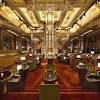

In [4]:
from PIL import Image
path = '/content/data/'
im = Image.open(path + 'art deco/art deco0.png')
im.to_thumb(128,128)

In [5]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#9053) [Path('/content/data/tudor/tudor479.png'),Path('/content/data/tudor/tudor653.png'),Path('/content/data/tudor/tudor114.png'),Path('/content/data/tudor/tudor665.png'),Path('/content/data/tudor/tudor572.png'),Path('/content/data/tudor/tudor184.png'),Path('/content/data/tudor/tudor285.png'),Path('/content/data/tudor/tudor134.png'),Path('/content/data/tudor/tudor499.png'),Path('/content/data/tudor/tudor581.png')...]

making sure there are no corrupt files:

In [6]:
failed = verify_images(filenames)
failed

(#0) []

# **DataLoaders**


Quick summary of the doc:

In [6]:
??DataLoaders

# **Fastai data block API**


In [8]:
architecture = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
doc(DataBlock)

In [10]:
doc(Resize)

In [11]:
dls = architecture.dataloaders(path)

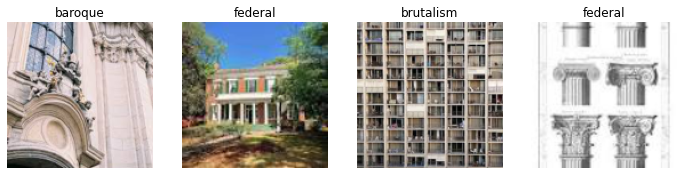

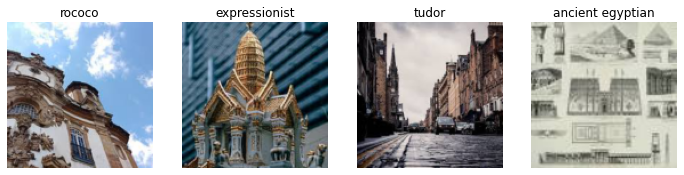

In [12]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

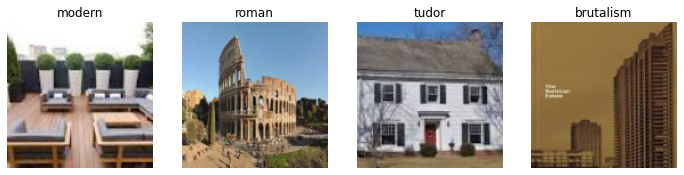

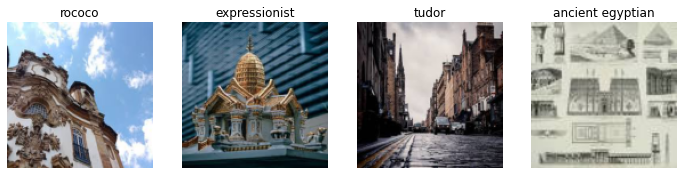

In [13]:
architecture = architecture.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

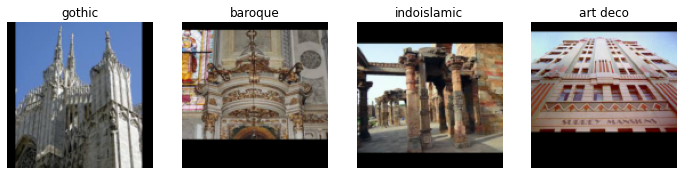

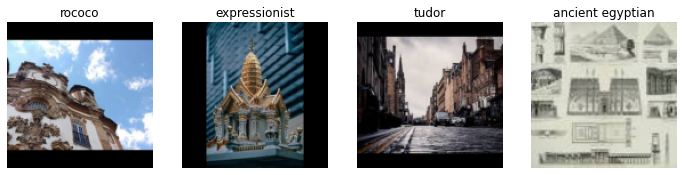

In [14]:
architecture = architecture.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

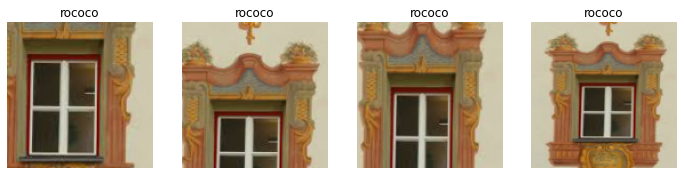

In [15]:
architecture = architecture.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
# the unique=True piece here is just to force our sanity check to give us the same image over and over again, 
# ofcourse each time with the random transform applied to it

In [18]:
our_out_of_the_box_model = cnn_learner(dls, resnet50, metrics=error_rate)
our_out_of_the_box_model.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.717485,2.028056,0.563536,01:06


epoch,train_loss,valid_loss,error_rate,time
0,1.978235,1.638090,0.492818,01:27
1,1.549505,1.449475,0.427624,01:27
2,1.122805,1.357920,0.402762,01:28


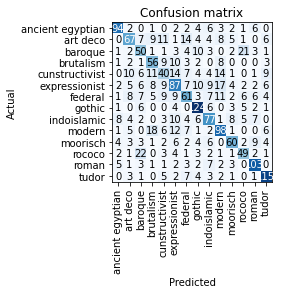

In [19]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

In [20]:
#interp.plot_top_losses(2, nrows=1)

def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)



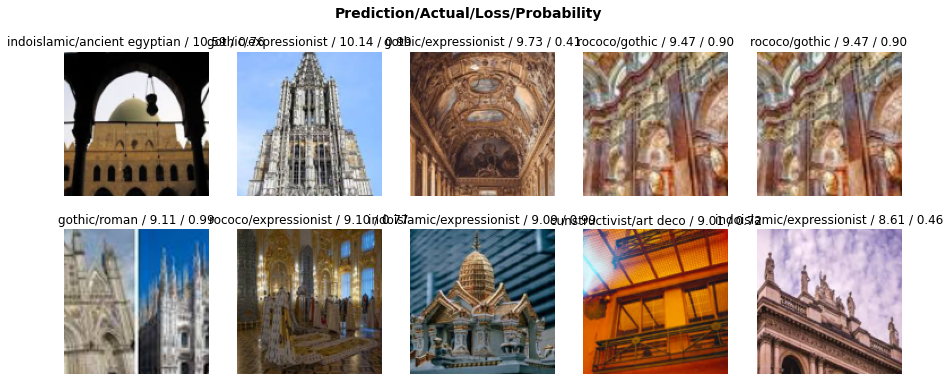

In [21]:
plot_top_losses_fix(interp, 10, nrows=2)

In [22]:
# saving our model, by default in a folder called 'models'.
our_out_of_the_box_model.save('good_model')
#creating an serialized pickle object of our model, the export.pkl file
our_out_of_the_box_model.export()

In [22]:
ls

data/  data.zip  export.pkl  gdrive/  models/  sample_data/


# **Loading a model & inference:**

In [24]:
our_out_of_the_box_model_inference = load_learner('export.pkl')
# let's test our model on an image
our_out_of_the_box_model_inference.predict('/content/data/modern/modern101.png')
# this will return the predicted category, the index of this predicted category, and the probabilities of each category

('expressionist',
 TensorBase(5),
 TensorBase([4.7753e-03, 2.5152e-02, 5.1793e-04, 4.0738e-02, 4.2338e-03, 6.1465e-01, 4.5408e-02, 2.2867e-03, 9.1173e-03, 2.5046e-01, 6.2986e-04, 5.1209e-04, 1.3096e-03, 2.1098e-04]))

In [ ]:
our_out_of_the_box_model_inference.dls.vocab